In [4]:
import cv2
import time
import numpy as np
import os
import psutil  # Import psutil for memory usage
from keras.models import load_model
from IPython.display import display, Image, clear_output

def preprocess_image(img, target_shape=(224, 224)):
    resized_img = cv2.resize(img, target_shape)
    return resized_img

def polarization_filtering(eye_region, target_shape=(224, 224)):
    # Convert the eye region to grayscale
    gray_eye = cv2.cvtColor(eye_region, cv2.COLOR_BGR2GRAY)

    # Apply a GaussianBlur to the grayscale eye region
    blurred_eye = cv2.GaussianBlur(gray_eye, (15, 15), 0)

    # Use adaptive thresholding to obtain a binary mask
    _, binary_mask = cv2.threshold(blurred_eye, 200, 255, cv2.THRESH_BINARY)

    # Use the binary mask to create a mask for the original eye region
    masked_eye = cv2.bitwise_and(eye_region, eye_region, mask=binary_mask)

    # Invert the binary mask to get the reg ions with reflections
    inverted_mask = cv2.bitwise_not(binary_mask)

    # Create a mask for the reflection regions
    reflection_mask = cv2.bitwise_and(eye_region, eye_region, mask=inverted_mask)

    # Add the reflection regions to the original eye region
    filtered_eye = cv2.addWeighted(eye_region, 1, reflection_mask, 0.5, 0)

    # Resize the filtered eye region to match the target size
    filtered_eye = cv2.resize(filtered_eye, target_shape)

    return filtered_eye

def display_eye_and_predictions(eye_region, predictions, identifier=""):
    cv2.putText(eye_region, f"Predictions: {predictions} {identifier}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    rgb_eye_region = cv2.cvtColor(eye_region, cv2.COLOR_BGR2RGB)
    display(Image(data=cv2.imencode('.png', rgb_eye_region)[1].tobytes(), format='png'))

start_total_time = time.time()

# Load VGG model
vgg_model_path = "VGG_RNR_model.h5"
vgg_model = load_model(vgg_model_path)

# Load EfficientNet model
efficientnet_model_path = 'efficientnet_custom_c_n_model_MRL.h5'
efficientnet_model = load_model(efficientnet_model_path)

cap = cv2.VideoCapture(0) 
evaluation_duration = 30
start_time = time.time()

output_folder_vgg = 'output_images_RNR'
output_folder_efficientnet = 'output_images_BC'
os.makedirs(output_folder_vgg, exist_ok=True)
os.makedirs(output_folder_efficientnet, exist_ok=True)

eye_images_vgg = []
eye_images_efficientnet = []

while time.time() - start_time < evaluation_duration:
    ret, frame = cap.read()

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray_frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)

        for (ex, ey, ew, eh) in eyes:
            eye_region = frame[y+ey:y+ey+eh, x+ex:x+ex+ew]

            preprocessed_eye_vgg = preprocess_image(eye_region)
            preprocessed_eye_efficientnet = preprocess_image(eye_region, target_shape=(224, 224))

            input_data_vgg = np.expand_dims(preprocessed_eye_vgg, axis=0)
            input_data_efficientnet = np.expand_dims(preprocessed_eye_efficientnet, axis=0)

            prediction_vgg = vgg_model.predict(input_data_vgg)
            prediction_efficientnet = efficientnet_model.predict(input_data_efficientnet)
            final_prediction_vgg = 1 if prediction_vgg[0, 1] > 0.50 else 0
            final_prediction_efficientnet = 1 if prediction_efficientnet[0, 1] > 0.5 else 0
            # Save frame in 'output_images_RNR' based on VGG prediction
            vgg_folder = output_folder_vgg
            if final_prediction_vgg == 1:
                vgg_folder = os.path.join(output_folder_vgg, f"eye_{len(eye_images_vgg)}_class_{final_prediction_vgg}_F")
                os.makedirs(vgg_folder, exist_ok=True)
                filtered_eye = polarization_filtering(eye_region)
                cv2.imwrite(os.path.join(vgg_folder, f"eye_{len(eye_images_vgg)}_class_{final_prediction_vgg}.png"), cv2.cvtColor(eye_region, cv2.COLOR_BGR2RGB))
                cv2.imwrite(os.path.join(vgg_folder, f"eye_{len(eye_images_vgg)}_class_{final_prediction_vgg}_F.png"), cv2.cvtColor(filtered_eye, cv2.COLOR_BGR2RGB))

            display_eye_and_predictions(eye_region, f"VGG: {final_prediction_vgg}", identifier=f"EfficientNet: {final_prediction_efficientnet}")

            eye_images_vgg.append((preprocessed_eye_vgg, final_prediction_vgg))

            # Pass frames to EfficientNet regardless of VGG predictions
            efficientnet_prediction = efficientnet_model.predict(input_data_efficientnet)
            final_prediction_efficientnet = 1 if efficientnet_prediction[0, 1] > 0.5 else 0
            efficientnet_folder = output_folder_efficientnet
            if final_prediction_vgg == 1:
                efficientnet_folder = os.path.join(output_folder_efficientnet, f"eye_{len(eye_images_efficientnet)}_class_{final_prediction_vgg}_F")
                os.makedirs(efficientnet_folder, exist_ok=True)
                cv2.imwrite(os.path.join(efficientnet_folder, f"eye_{len(eye_images_efficientnet)}_class_{final_prediction_vgg}_F.png"), cv2.cvtColor(filtered_eye, cv2.COLOR_BGR2RGB))
            else:
                cv2.imwrite(os.path.join(efficientnet_folder, f"eye_{len(eye_images_efficientnet)}_class_{final_prediction_efficientnet}.png"), cv2.cvtColor(preprocessed_eye_efficientnet, cv2.COLOR_BGR2RGB))
            eye_images_efficientnet.append((preprocessed_eye_efficientnet, final_prediction_efficientnet))

            clear_output(wait=True)

            time.sleep(1.0)

end_total_time = time.time()

total_time = end_total_time - start_total_time
print(f"Total time: {total_time:.2f} seconds")

process = psutil.Process(os.getpid())
memory_used = process.memory_info().rss
print(f"Memory used: {memory_used / (1024 ** 2):.2f} MB")

# Save output images for VGG model
for i, (eye_img, pred) in enumerate(eye_images_vgg):
    file_name = os.path.join(vgg_folder, f"eye_{i}_class_{pred}.png")
    cv2.imwrite(file_name, cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))

# Save output images for EfficientNet model
for i, (eye_img, pred) in enumerate(eye_images_efficientnet):
    if pred == 1:
        file_name = os.path.join(efficientnet_folder, f"eye_{i}_class_{pred}_F.png")
    else:
        file_name = os.path.join(efficientnet_folder, f"eye_{i}_class_{pred}.png")
    cv2.imwrite(file_name, cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))

cap.release()
cv2.destroyAllWindows()

Total time: 40.04 seconds
Memory used: 1541.54 MB


In [6]:
import cv2
import time
import numpy as np
import os
import psutil  # Import psutil for memory usage
from keras.models import load_model
from IPython.display import display, Image, clear_output

def preprocess_image(img, target_shape=(224, 224)):
    resized_img = cv2.resize(img, target_shape)
    return resized_img

def color_normalization(eye_region):
    lab = cv2.cvtColor(eye_region, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE-enhanced L-channel with the original A and B channels
    limg = cv2.merge((cl, a, b))

    # Convert LAB back to BGR
    filtered_eye = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return filtered_eye

def display_eye_and_predictions(eye_region, predictions, identifier=""):
    #cv2.putText(eye_region, f"Predictions: {predictions} {identifier}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    rgb_eye_region = cv2.cvtColor(eye_region, cv2.COLOR_BGR2RGB)
    display(Image(data=cv2.imencode('.png', rgb_eye_region)[1].tobytes(), format='png'))

start_total_time = time.time()

# Load VGG model
vgg_model_path = "VGG_RNR_model.h5"
vgg_model = load_model(vgg_model_path)

# Load EfficientNet model
efficientnet_model_path = 'efficientnet_custom_c_n_model_MRL.h5'
efficientnet_model = load_model(efficientnet_model_path)

cap = cv2.VideoCapture(0) 
evaluation_duration = 30
start_time = time.time()

output_folder_vgg = 'output_images_RNR'
output_folder_efficientnet = 'output_images_BC'
os.makedirs(output_folder_vgg, exist_ok=True)
os.makedirs(output_folder_efficientnet, exist_ok=True)

eye_images_vgg = []
eye_images_efficientnet = []

while time.time() - start_time < evaluation_duration:
    ret, frame = cap.read()

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray_frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)

        for (ex, ey, ew, eh) in eyes:
            eye_region = frame[y+ey:y+ey+eh, x+ex:x+ex+ew]

            preprocessed_eye_vgg = preprocess_image(eye_region)
            preprocessed_eye_efficientnet = preprocess_image(eye_region, target_shape=(224, 224))
     # Apply color normalization for reflection removal
            #normalized_eye = color_normalization(eye_region)
            input_data_vgg = np.expand_dims(preprocessed_eye_vgg, axis=0)
            input_data_efficientnet = np.expand_dims(preprocessed_eye_efficientnet, axis=0)

            prediction_vgg = vgg_model.predict(input_data_vgg)
            prediction_efficientnet = efficientnet_model.predict(input_data_efficientnet)
            final_prediction_vgg = 1 if prediction_vgg[0, 1] > 0.50 else 0
            final_prediction_efficientnet = 1 if prediction_efficientnet[0, 1] > 0.5 else 0
            # Save frame in 'output_images_RNR' based on VGG prediction
            vgg_folder = output_folder_vgg
            if final_prediction_vgg == 1:
                vgg_folder = os.path.join(output_folder_vgg, f"eye_{len(eye_images_vgg)}_class_{final_prediction_vgg}_F")
                os.makedirs(vgg_folder, exist_ok=True)
                filtered_eye = color_normalization(eye_region)
                cv2.imwrite(os.path.join(vgg_folder, f"eye_{len(eye_images_vgg)}_class_{final_prediction_vgg}.png"), cv2.cvtColor(eye_region, cv2.COLOR_BGR2RGB))
                cv2.imwrite(os.path.join(vgg_folder, f"eye_{len(eye_images_vgg)}_class_{final_prediction_vgg}_F.png"), cv2.cvtColor(filtered_eye, cv2.COLOR_BGR2RGB))

            display_eye_and_predictions(eye_region, f"VGG: {final_prediction_vgg}", identifier=f"EfficientNet: {final_prediction_efficientnet}")

            eye_images_vgg.append((preprocessed_eye_vgg, final_prediction_vgg))

            # Pass frames to EfficientNet regardless of VGG predictions
            efficientnet_prediction = efficientnet_model.predict(input_data_efficientnet)
            final_prediction_efficientnet = 1 if efficientnet_prediction[0, 1] > 0.5 else 0
            efficientnet_folder = output_folder_efficientnet
            if final_prediction_vgg == 1:
                efficientnet_folder = os.path.join(output_folder_efficientnet, f"eye_{len(eye_images_efficientnet)}_class_{final_prediction_vgg}_F")
                os.makedirs(efficientnet_folder, exist_ok=True)
                cv2.imwrite(os.path.join(efficientnet_folder, f"eye_{len(eye_images_efficientnet)}_class_{final_prediction_vgg}_F.png"), cv2.cvtColor(filtered_eye, cv2.COLOR_BGR2RGB))
            else:
                cv2.imwrite(os.path.join(efficientnet_folder, f"eye_{len(eye_images_efficientnet)}_class_{final_prediction_efficientnet}.png"), cv2.cvtColor(preprocessed_eye_efficientnet, cv2.COLOR_BGR2RGB))
            eye_images_efficientnet.append((preprocessed_eye_efficientnet, final_prediction_efficientnet))

            clear_output(wait=True)

            time.sleep(0.25)

end_total_time = time.time()

total_time = end_total_time - start_total_time
print(f"Total time: {total_time:.2f} seconds")

process = psutil.Process(os.getpid())
memory_used = process.memory_info().rss
print(f"Memory used: {memory_used / (1024 ** 2):.2f} MB")

# Save output images for VGG model
for i, (eye_img, pred) in enumerate(eye_images_vgg):
    file_name = os.path.join(vgg_folder, f"eye_{i}_class_{pred}.png")
    cv2.imwrite(file_name, cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))

# Save output images for EfficientNet model
for i, (eye_img, pred) in enumerate(eye_images_efficientnet):
    if pred == 1:
        file_name = os.path.join(efficientnet_folder, f"eye_{i}_class_{pred}_F.png")
    else:
        file_name = os.path.join(efficientnet_folder, f"eye_{i}_class_{pred}.png")
    cv2.imwrite(file_name, cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))

cap.release()
cv2.destroyAllWindows()

Total time: 39.38 seconds
Memory used: 1876.54 MB




1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 47ms/step
Accuracy: 93.74%


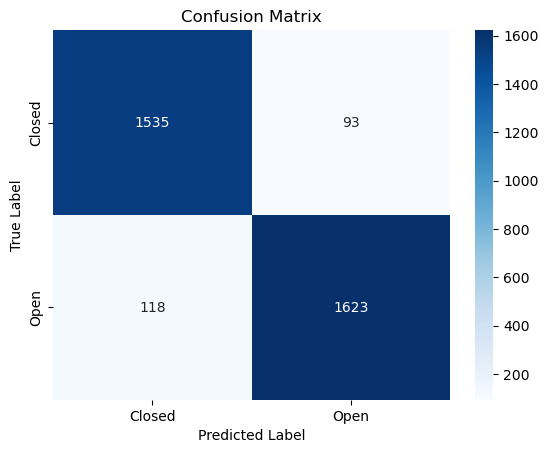

Classification Report:
              precision    recall  f1-score   support

      Closed       0.93      0.94      0.94      1628
        Open       0.95      0.93      0.94      1741

    accuracy                           0.94      3369
   macro avg       0.94      0.94      0.94      3369
weighted avg       0.94      0.94      0.94      3369



In [2]:
import cv2
import numpy as np
import os
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_image(img, target_shape=(224, 224)):
    resized_img = cv2.resize(img, target_shape)
    return resized_img

def color_normalization(eye_region):
    lab = cv2.cvtColor(eye_region, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE-enhanced L-channel with the original A and B channels
    limg = cv2.merge((cl, a, b))

    # Convert LAB back to BGR
    filtered_eye = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return filtered_eye

def vgg_predict_and_normalize(model, img):
    preprocessed_eye_vgg = preprocess_image(img)
    input_data_vgg = np.expand_dims(preprocessed_eye_vgg, axis=0)

    prediction_vgg = model.predict(input_data_vgg)
    final_prediction_vgg = 1 if prediction_vgg[0, 1] > 0.50 else 0

    if final_prediction_vgg == 1:
        normalized_eye = color_normalization(img)
        return normalized_eye
    else:
        return img

def efficientnet_predict(model, img):
    preprocessed_eye_efficientnet = preprocess_image(img, target_shape=(224, 224))
    input_data_efficientnet = np.expand_dims(preprocessed_eye_efficientnet, axis=0)

    efficientnet_prediction = model.predict(input_data_efficientnet)
    final_prediction_efficientnet = 1 if efficientnet_prediction[0, 1] > 0.5 else 0

    return final_prediction_efficientnet

# Load VGG model
vgg_model_path = "VGG_RNR_model.h5"
vgg_model = load_model(vgg_model_path)

# Load EfficientNet model
efficientnet_model_path = 'efficientnet_custom_c_n_model_MRL.h5'
efficientnet_model = load_model(efficientnet_model_path)

# Specify the directory containing closed and open eye images
directory_path = r"C:\Users\yashu\Downloads\Desktop\final year project\data\test_combined_model"

closed_eye_folder = os.path.join(directory_path, "closed_eye")
open_eye_folder = os.path.join(directory_path, "open eye")

# Lists to store predictions and true labels
predictions = []
true_labels = []

# Process closed eye images
for filename in os.listdir(closed_eye_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(closed_eye_folder, filename)
        eye_img = cv2.imread(img_path)

        processed_eye = vgg_predict_and_normalize(vgg_model, eye_img)
        prediction_efficientnet = efficientnet_predict(efficientnet_model, processed_eye)

        # Append the prediction and true label
        predictions.append(prediction_efficientnet)
        true_labels.append(0)  # Assuming 0 represents closed eye

# Process open eye images
for filename in os.listdir(open_eye_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(open_eye_folder, filename)
        eye_img = cv2.imread(img_path)

        processed_eye = vgg_predict_and_normalize(vgg_model, eye_img)
        prediction_efficientnet = efficientnet_predict(efficientnet_model, processed_eye)

        # Append the prediction and true label
        predictions.append(prediction_efficientnet)
        true_labels.append(1)  # Assuming 1 represents open eye

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2%}")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
report = classification_report(true_labels, predictions, target_names=['Closed', 'Open'])
print("Classification Report:")
print(report)
